In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import numpy as np
import spacy
import random


from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x)

In [3]:
class TransformerModel(nn.Module):
    
    def __init__(self, intoken, outtoken ,hidden, enc_layers=2, dec_layers=2, dropout=.1, nheads=2, ff_model=128):
        super(TransformerModel, self).__init__()
        
        self.encoder = nn.Embedding(intoken, hidden)
        self.pos_encoder = PositionalEncoding(hidden, dropout)

        self.decoder = nn.Embedding(outtoken, hidden) 
        self.pos_decoder = PositionalEncoding(hidden, dropout)
        
        
        encoder_layers = TransformerEncoderLayer(d_model=hidden, nhead = nheads, dim_feedforward = ff_model, dropout=dropout, activation='relu')
        self.transformer_encoder = TransformerEncoder(encoder_layers, enc_layers)

        encoder_layers = TransformerDecoderLayer(hidden, nheads, ff_model, dropout, activation='relu')
        self.transformer_decoder = TransformerDecoder(encoder_layers, dec_layers)        

        self.fc_out = nn.Linear(hidden, outtoken)

        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None

        
    def generate_square_subsequent_mask(self, sz, sz1=None):
        
        if sz1 == None:
            mask = torch.triu(torch.ones(sz, sz), 1)
        else:
            mask = torch.triu(torch.ones(sz, sz1), 1)
            
        return mask.masked_fill(mask==1, float('-inf'))

    def make_len_mask_enc(self, inp):
        return (inp == de_pad_idx).transpose(0, 1)   #(batch_size, output_seq_len)
    
    def make_len_mask_dec(self, inp):
        return (inp == en_pad_idx).transpose(0, 1) #(batch_size, input_seq_len)
    


    def forward(self, src, trg): #SRC: (seq_len, batch_size)

        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(trg.device)
            

        #Adding padding mask
        src_pad_mask = self.make_len_mask_enc(src)
        trg_pad_mask = self.make_len_mask_dec(trg)
             

        #Add embeddings Encoder
        src = self.encoder(src)  #Embedding, (seq_len, batch_size, d_model)
        src = self.pos_encoder(src)   #Pos embedding
        
        
        #Add embedding decoder
        trg = self.decoder(trg) #(seq_len, batch_size, d_model)
        trg = self.pos_decoder(trg)

        
        memory = self.transformer_encoder(src, None, src_pad_mask)
        output = self.transformer_decoder(tgt = trg, memory = memory, tgt_mask = self.trg_mask, memory_mask = None, 
                                          tgt_key_padding_mask = trg_pad_mask, memory_key_padding_mask = src_pad_mask)

        output = self.fc_out(output)

        return output

In [5]:
import spacy.cli
import en_core_web_sm
import de_core_news_sm


spacy.cli.download("en_core_web_sm")
spacy.cli.download("de_core_news_sm")


spacy_ger = de_core_news_sm.load()
spacy_eng = en_core_web_sm.load()

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [25]:
def tokenizer_de(text):
    return [tok.text for tok in spacy_ger.tokenizer(text)]

def tokenizer_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]

german = Field(tokenize=tokenizer_de, lower=True)

english = Field(
    tokenize=tokenizer_eng, lower=True, init_token="<sos>", eos_token="<eos>"
)

In [26]:
train_data, valid_data, test_data = Multi30k.splits(
    exts=(".de", ".en"), fields=(german, english))

In [27]:
german.build_vocab(train_data, max_size=10000, min_freq=2)
english.build_vocab(train_data, max_size=10000, min_freq=2)

In [ ]:
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Model Hyperparameter
input_size_encoder = len(german.vocab)
input_size_decoder = len(english.vocab)
output_size = len(english.vocab)

d_model = 256

model = TransformerModel(input_size_encoder, input_size_decoder ,d_model, enc_layers=1, dec_layers=1, dropout=.1, nheads=1, ff_model=1028).to(device)

maxlen = 50

model.load_state_dict(torch.load("../models/transformer"))

In [16]:
def beam(phrase, k):
    
    model.eval()
    memory = get_out_encoder(phrase)

    sos = english.vocab.stoi["<sos>"]
    tgt = [sos]

    with torch.no_grad():

        trg = torch.Tensor(tgt).long().unsqueeze(1).to(device)
        trg = model.decoder(trg)
        trg = model.pos_decoder(trg)

        out = model.transformer_decoder(tgt = trg, memory = memory)
        out = F.softmax(model.fc_out(out), dim=-1)[-1].squeeze()

        args = out.argsort()[-k:].detach().cpu().numpy()
        probs = out[args].detach().cpu().numpy()

        probs = np.log(probs)
        possible = list(zip([tgt + [args[i]] for i in range(k)], probs))
        
        for i in range(maxlen):

            test=  []
            for j in range(k):

                tmp_tgt, tmp_prob = possible[j]

                if tmp_tgt[-1] == english.vocab.stoi["<eos>"]:
                    test.append(possible[j])

                else:
                    trg = torch.Tensor(tmp_tgt).long().unsqueeze(1).to(device)
                    trg = model.decoder(trg)
                    trg = model.pos_decoder(trg)

                    out = model.transformer_decoder(tgt = trg, memory = memory)
                    out = F.softmax(model.fc_out(out), dim=-1)[-1].squeeze()

                    tmp_args = out.argsort()[-k:].detach().cpu().numpy()
                    tmp_probs = out[tmp_args].detach().cpu().numpy()
                    tmp_probs = (tmp_prob + np.log(tmp_probs))/(len(tmp_tgt)-1)

                    for r in range(k): 
                        test.append((tmp_tgt + [tmp_args[r]], tmp_probs[r]))


            possible = sorted(test, key=lambda x:x[1], reverse=True)[:k]
            
    return possible


def convert(x):
    
    sentence = x[0]
    sentence = [english.vocab.itos[i] for i in sentence]
    
    return (" ".join(sentence), x[1])

def get_out_encoder(src):
    
    model.eval()
    tokens = [token.text.lower() for token in spacy_ger(src)]

    text_to_indices = [german.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)    

    with torch.no_grad():
        
        emb_src = model.encoder(sentence_tensor)
        emb_src = model.pos_encoder(emb_src)

        memory = model.transformer_encoder(emb_src)

        return memory

In [312]:
list(map(convert, beam("zwei personen stehen auf einem grasbewachsenen hang vor einem großen kreuz aus holz.", 1)))

[('<sos> two people stand on a grassy hillside in front of a large wooden cross . <eos>',
  -0.001122942)]

In [53]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=30,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device,
)

In [54]:
en_pad_idx = 1
de_pad_idx = 1

criterion = nn.CrossEntropyLoss(ignore_index=en_pad_idx)

In [55]:
run_validation()

tensor(1.8572, device='cuda:0')

In [303]:
def multi_head_attention_forward(
    query,
    key,
    value,
    num_heads,
    in_proj_weight,
    in_proj_bias,
):

    tgt_len, bsz, embed_dim = query.size()

    head_dim = embed_dim // num_heads
    scaling = float(head_dim) ** -0.5

    # self-attention
    q, k, v = F.linear(query, in_proj_weight, in_proj_bias).chunk(3, dim=-1)

                  
    q = q * scaling

    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)


    src_len = k.size(1)

    attn_output_weights = torch.bmm(q, k.transpose(1, 2))

    attn_output_weights = F.softmax(attn_output_weights, dim=-1)
    return attn_output_weights

In [304]:
sentence = "zwei personen stehen auf einem grasbewachsenen hang vor einem großen kreuz aus holz."

In [305]:
model.eval()
tokens = [token.text.lower() for token in spacy_ger(sentence)]

text_to_indices = [german.vocab.stoi[token] for token in tokens]

# Convert to Tensor
sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)    

emb_src = model.encoder(sentence_tensor)
emb_src = model.pos_encoder(emb_src)

In [306]:
self_att = model.transformer_encoder.layers[0].self_attn

In [307]:
att_weights = multi_head_attention_forward(
                emb_src, emb_src, emb_src, self_att.num_heads,
                self_att.in_proj_weight, self_att.in_proj_bias)

In [308]:
import seaborn as sns
import matplotlib.pyplot as plt

In [309]:
att_weights = att_weights[0].detach().cpu().numpy()

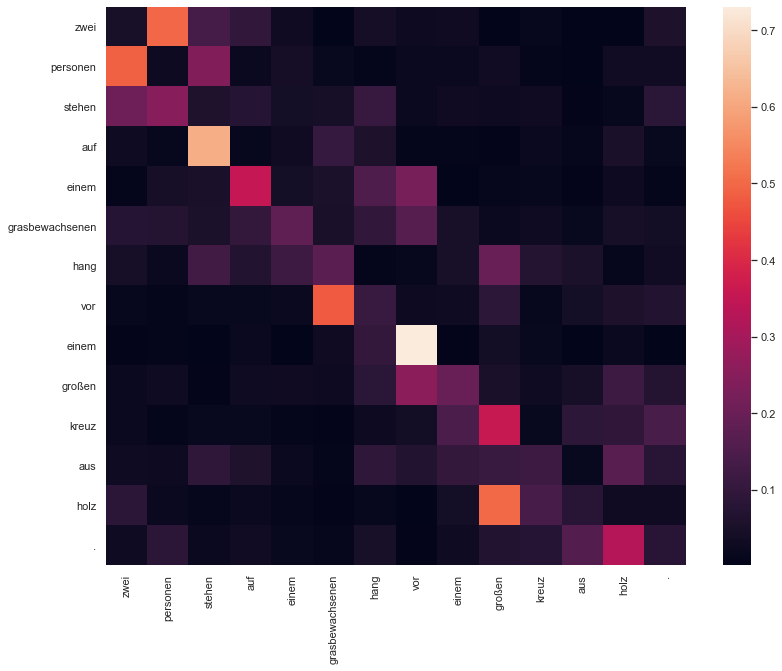

In [310]:
sns.heatmap(att_weights, xticklabels=tokens, yticklabels=tokens)

sns.set(rc={'figure.figsize':(13,10.27)})
plt.show()